In [36]:
import math

def fresnelPar(eta_2: float, theta: float) -> float:
    eta_1: float = 1
    cos_gamma_i: float = math.cos(theta)

    a: float = ((eta_1 / eta_2) * math.sin(theta))
    b: float = a * a

    if (b > 1): return 1

    cos_gamma_t: float = math.sqrt(1 - b)

    R: float = (eta_2 * cos_gamma_i - eta_1 * cos_gamma_t) / (eta_2 * cos_gamma_i + eta_1 * cos_gamma_t)

    return min(1, R * R)

def fresnelPer(eta_2: float, theta : float) -> float:
    eta_1: float = 1
    cos_gamma_i: float = math.cos(theta)

    a: float = ((eta_1 / eta_2) * math.sin(theta))
    b: float = a * a

    if (b > 1): return 1

    cos_gamma_t: float = math.sqrt(1 - b)

    R: float = (eta_1 * cos_gamma_i - eta_2 * cos_gamma_t) / (eta_1 * cos_gamma_i + eta_2 * cos_gamma_t)

    return min(1, R * R)


def fresnel(eta_parallel : float, eta_perpendic : float, theta : float) -> float:
    return 0.5 * (fresnelPer(eta_perpendic, theta) + fresnelPar(eta_parallel, theta))

def fresnel2(eta : float, x: float) -> float:
    F_0: float = pow(1 - eta, 2) / pow(1 + eta, 2)
    return F_0 + (1 - F_0) * pow(1 - x, 5)


In [37]:
def T(absorb : float, gamma_t : float) -> float:
    l : float = 1 + math.cos(2 * gamma_t)
    return math.exp(-2 * absorb * l)

In [38]:
def calc_lenght(a: list) -> float:
    length: float = 0
    for coord in a:
        length += coord ** 2
    return math.sqrt(length)

def normalise(a: list) -> list:
    lenght: float = calc_lenght(a)
    for i in range(len(a)):
        a[i] /= lenght
    return a

def dot(a: list, b: list) -> float:
    if(len(a) != len(b)): return float('nan')
    dotpr: float = 0
    for i in range(len(a)):
        dotpr += a[i] * b[i]

def minus(a: list, b: list) -> list:
    x = a[0] - b[0]
    y = a[1] - b[1]
    z = a[2] - b[2]

    return[x, y, z]

def cross(a: list, b: list) -> list:
    x = a[1]*b[2] - a[2]*b[1]
    y = a[2]*b[0] - a[0]*b[2]
    z = a[0]*b[1] - a[1]*b[0]
    
    return[x, y, z]

def rotate_z(a: list, rad: float) -> list:
    x: float = a[0] * math.cos(rad) - a[1] * math.sin(rad)
    y: float = a[0] * math.sin(rad) + a[1] * math.cos(rad)
    z: float = a[2]

    return [x, y, z]


In [39]:


def absorption(absorb: float, p: int, h: float, refrac: float, eta_parallel: float,  eta_perpendic: float, theta: float) -> float:
    gamma_i: float = math.asin(h)

    if (p == 0):
        return fresnel(eta_parallel, eta_perpendic, gamma_i)
    '''
    gamma_t : float = math.asin(h / eta_perpendic)
    fres : float= fresnel(eta_parallel, eta_perpendic, gamma_i)
    inv_fres: float = fresnel(1 / eta_parallel, 1 / eta_perpendic, gamma_t)

    t : float= T(absorb, gamma_t)

    return (1 - fres) * (1 - fres) * pow(inv_fres, p - 1) * pow(t, p)
    '''

    gamma_t : float = math.asin(h / eta_perpendic)
    fres : float = fresnel(eta_parallel, eta_perpendic, math.cos(theta) * math.sqrt(1 - (h * h)))
    t : float = T(absorb, gamma_t)
    return (1 - fres) * (1 - fres) * pow(fres, p - 1) * pow(t, p)

In [40]:
def B_index(theta :float, eta : float) -> float :
    sin_theta : float = math.sin(theta)
    return math.sqrt(eta * eta - sin_theta * sin_theta) / math.cos(theta)


In [41]:
epsilon = 0.00001

def sign(x: float) -> int:
    if x > 0: return 1
    if x < 0: return -1
    return 0


def LinearSolver(a: float, b: float) -> list:
    roots: list = [0, 0, 0, 0]
    # roots: list = [float('nan'), float('nan'), float('nan'), float('nan')]

    if (abs(a) > epsilon):
        roots[0] = -b / a
        roots[3] = 1

    return roots


def QuadraticSolver( a: float,  b: float ,  c: float) -> list:
    roots: list = [0, 0, 0, 0]
    # roots: list = [float('nan'), float('nan'),float('nan'), float('nan')]

    if (abs(a) < epsilon): return LinearSolver(b, c)

    else:
        D : float = b * b - 4 * a * c

        if (abs(D) < epsilon):
            roots[0] = -b / (2 * a)
            roots[1] = -b / (2 * a)
            roots[3] = 2

        elif (D > 0):
            delta: float = math.sqrt(D)
            roots[0] = (-b + delta) / (2 * a)
            roots[1] = (-b - delta) / (2 * a)
            roots[3] = 2

    return roots


def NormalizedCubicSolver(A: float,  B: float, C: float) -> list:
    roots: list = [0, 0, 0, 0]
    # roots: list = [float('nan'), float('nan'),float('nan'), float('nan')]

    if (abs(C) < epsilon):
        roots = QuadraticSolver(1, A, B)
        roots[int(roots[3])] = 0
        roots[3] += 1

    else:
        Q: float = (3 * B - A * A) / 9
        R: float = (9 * A * B - 27 * C - 2 * A * A * A) / 54
        D: float = Q * Q * Q + R * R

        if (D > 0):
            sqrtD: float = math.sqrt(D)
            s: float = sign(R + sqrtD) * pow(abs(R + sqrtD), 1.0 / 3.0)
            t: float = sign(R - sqrtD) * pow(abs(R - sqrtD), 1.0 / 3.0)

            roots[0] = (-A / 3 + (s + t))
            roots[3] = 1
        
        else:
            theta: float = math.acos(R / math.sqrt(-(Q * Q * Q)))
            sqrtQ: float = math.sqrt(-Q)
            roots[0] = (2 * sqrtQ * math.cos(theta / 3) - A / 3)
            roots[1] = (2 * sqrtQ * math.cos((theta + 2 * math.pi) / 3) - A / 3)
            roots[2] = (2 * sqrtQ * math.cos((theta + 4 * math.pi) / 3) - A / 3)
            roots[3] = 3
        
    return roots


def cubic_solver(a: float, b: float, c: float, d: float) -> list:
    if (abs(a) < epsilon):
        return QuadraticSolver(b, c, d)
    
    else:
        return NormalizedCubicSolver(b / a, c / a, d / a)


In [42]:
def calc_roots(p , eta_perpendic, phi) -> list:
    c : float = math.asin(1 / eta_perpendic)
    return cubic_solver(-8 * (p * c / (math.pi * math.pi * math.pi)), 0, (6 * p * c / math.pi) - 2, p * math.pi - phi)

In [43]:
def NP(p: int, theta_d : float, phi: float, eta : float,  absorb : float) -> float:
    eta_perpendic : float = B_index(theta_d, eta)
    eta_parallel : float = (eta * eta) / eta_perpendic

    roots : list = calc_roots(p, eta_perpendic, phi)
    res : float = 0
    for gamma_i in roots:
        h: float = math.sin(gamma_i)
        if(h >= epsilon): continue
        res += absorption(absorb, p, h, eta, eta_parallel, eta_perpendic, theta_d)
        
    return res



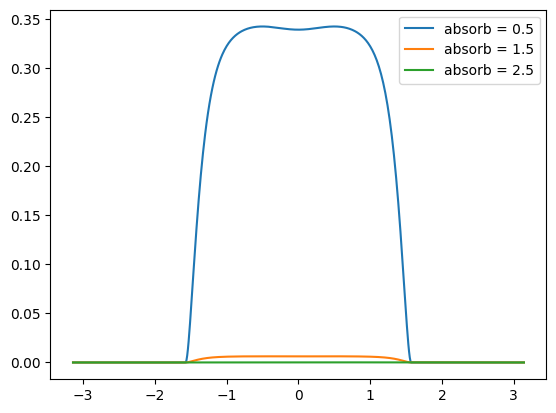

In [44]:
import matplotlib.pyplot as plt

p: float = 1
eta: float =  1.55

abs1: float = 0.5
abs2: float = 1.5
abs3: float = 2.5

phi: float = math.pi

A1 = []
A2 = []
A3 = []

thetas = []
theta = math.pi
while True:
    if theta < -math.pi: break
    A1.append(NP(p, theta, phi, eta, abs1))
    A2.append(NP(p, theta, phi, eta, abs2))
    A3.append(NP(p, theta, phi, eta, abs3))
    thetas.append(theta)
    theta -= 0.01

plt.plot(thetas, A1, label = "absorb = 0.5") 
plt.plot(thetas, A2, label = "absorb = 1.5") 
plt.plot(thetas, A3, label = "absorb = 2.5") 
plt.legend() 
plt.show()

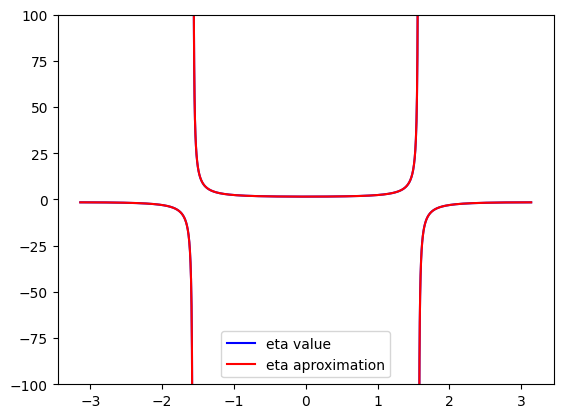

In [45]:
eta: float =  1.55
eta_tick = []
eta_tick_aprox = []
thetas = []

theta = math.pi
while True:
    if theta < -math.pi: break
    eta_tick.append(B_index(theta, eta))
    eta_tick_aprox.append((1.19 / math.cos(theta)) + 0.36 * math.cos(theta))
    thetas.append(theta)
    theta -= 0.001

eta_tick_split = [[]]
eta_tick_aprox_split = [[]]
thetas_split = [[]]
list_index = 0

for i in range(len(eta_tick)):
    if(i == 0): continue

    if((eta_tick[i] > 0 and eta_tick[i - 1] < 0) or (eta_tick[i] < 0 and eta_tick[i - 1] > 0)):
        eta_tick_split.append([])
        thetas_split.append([])
        eta_tick_aprox_split.append([])
        list_index += 1

    eta_tick_split[list_index].append(eta_tick[i])
    eta_tick_aprox_split[list_index].append(eta_tick_aprox[i])
    # thetas_split[list_index].append(math.degrees(thetas[i]))
    thetas_split[list_index].append(thetas[i])

ax = plt.gca()
ax.set_ylim([-100, 100])
for i in range(len(eta_tick_split)):
    if i == 0:
        plt.plot(thetas_split[i], eta_tick_split[i], label = "eta value", color="blue")
        plt.plot(thetas_split[i], eta_tick_aprox_split[i], label = "eta aproximation", color="red")
    else:
        plt.plot(thetas_split[i], eta_tick_split[i], color="blue")
        plt.plot(thetas_split[i], eta_tick_aprox_split[i], color="red")

# plt.plot(thetas, eta_tick_aprox, label = "aproximation") 
plt.legend() 
plt.show()

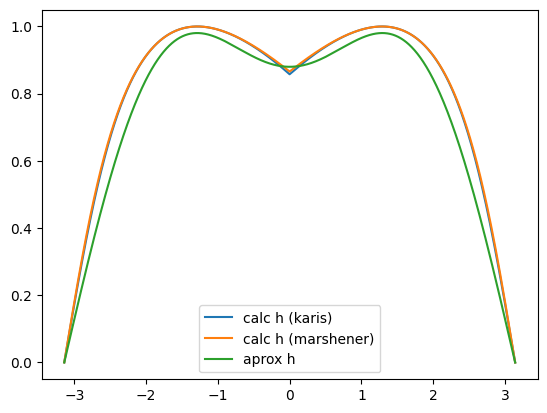

In [46]:
def calc_h(phi: float, inv_eta_tick: float) -> float:
    top: float = sign(phi) * math.cos(phi / 2)
    bottom: float = math.sqrt(1 + pow(inv_eta_tick, 2) - 2 * inv_eta_tick * sign(phi) * math.sin(phi / 2))

    return abs(top / bottom)

def get_h(phi: float, eta_perpendic: float) -> float:
    
    roots : list = calc_roots(1, eta_perpendic, phi)
    for gamma_i in roots:
        if not math.isnan(gamma_i): return math.sin(gamma_i)

h1 = []
h2 = []
h3 = []
phis = []

phi = math.pi
a = 0.6
while True:
    if phi < -math.pi: break
    h1.append(calc_h(phi, a))
    h2.append(get_h(abs(phi), (1/a)))
    h3.append((1 + a * (0.6 - 0.8 * math.cos(phi))) * math.cos(phi / 2))
    
    phis.append(phi)
    phi -= 0.001

plt.plot(phis, h1, label = "calc h (karis)") 
plt.plot(phis, h2, label = "calc h (marshener)") 
plt.plot(phis, h3, label = "aprox h") 
plt.legend() 
plt.show()

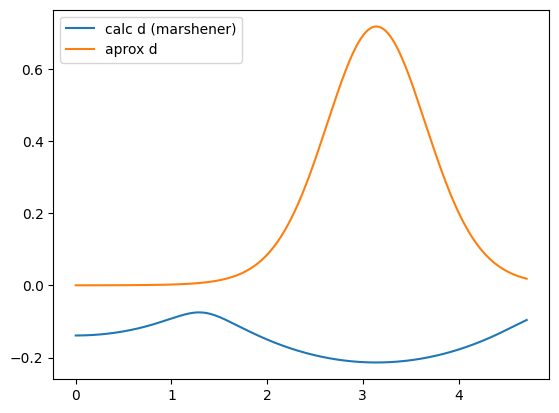

In [47]:



def inv_first_der(p: int, eta_perpendic: float, phi: float) -> float:
  h: float = (1 + a * (0.6 - 0.8 * math.cos(phi))) * math.cos(phi / 2)
  gamma_i: float = math.asin(h)
  c: float = math.asin( 1 / eta_perpendic )
  d_gamma: float = ((6 * p * c / math.pi) - 2) - 3 * 8 * (p * c / pow(math.pi, 3)) * gamma_i * gamma_i
  return math.sqrt(1 - h * h) / d_gamma

d1 = []
d2 = []
phis = []

phi = 1.5 * math.pi
while True:
    if phi < 0: break
    d1.append(inv_first_der(2, B_index(math.pi, 1.55), phi))
    d2.append(math.exp(-3.65 * math.cos(phi) - 3.98))
    
    phis.append(phi)
    phi -= 0.001

plt.plot(phis, d1, label = "calc d (marshener)") 
plt.plot(phis, d2, label = "aprox d") 
plt.legend() 
plt.show()

In [49]:
def NP_R_K(phi: float, theta_d : float, eta: float, view_light_angle: float) -> float:
    eta_perpendic: float = B_index(theta_d, eta)
    eta_parallel: float = (eta * eta) / eta_perpendic

    # gamma_i: float = -phi / 2
    # h: float = math.sin(gamma_i)
    res: float = 0.25 * math.cos(phi / 2)
    # res *= fresnel(eta_perpendic, eta_parallel, math.sqrt(abs(0.5 * (math.radians(1) + view_light_angle))))
    res *= fresnel2(eta_perpendic, math.sqrt(0.5 * (math.radians(1) + view_light_angle)))
    return res

def NP_R(phi: float, theta_d: float, eta: float)  -> float:
    eta_perpendic: float = B_index(theta_d, eta)
    eta_parallel: float = (eta * eta) / eta_perpendic 

    gamma_i: float = -phi / 2
    h: float = math.sin(gamma_i)

    #this one is from the implementation I found
    res: float = math.sqrt(1 - h * h)
    res *= fresnel(eta_perpendic, eta_parallel, gamma_i)
    return min(res, 1)

view = normalise([1, 1, 0])
light = normalise([1, 1, 1])

tangent = normalise([0, 0, -1])

np1 = []
np2 = []
phis = []

eta = 1.55
i = 0
while True:
    dotLightTangent: float = dot(light, tangent)
    dotViewTangent: float = dot(view, tangent)
    LT_P: list = normalise(light - dotLightTangent)
    VT_P: list = normalise(view - dotViewTangent)
    Normal: list = normalise(LT_P + VT_P)
    Binormal: list = normalise(cross(Normal, tangent))

    theta_r: float = math.acos(dot(VT_P, view))
    theta_i: float = math.acos(dot(LT_P, light))
    theta_d: float = (theta_r - theta_i) / 2

    phi_r : float = math.acos(dot(Binormal, VT_P))
    phi_i : float = math.acos(dot(Binormal, LT_P))
    phi : float = phi_r - phi_i

    
    np1.append(NP_R_K(phi, theta_d, eta, dot(view, light)))
    np2.append(NP_R(phi, theta_d, eta))
    phis.append(theta_d)

    if theta_d < -math.pi or i == 1000000: break
    light = rotate_z(light, 0.0175)
    i += 1
    


plt.plot(phis, np1, label = "NP_R_K") 
plt.plot(phis, np2, label = "NP_R") 
plt.legend() 
plt.show()

TypeError: unsupported operand type(s) for -: 'list' and 'NoneType'

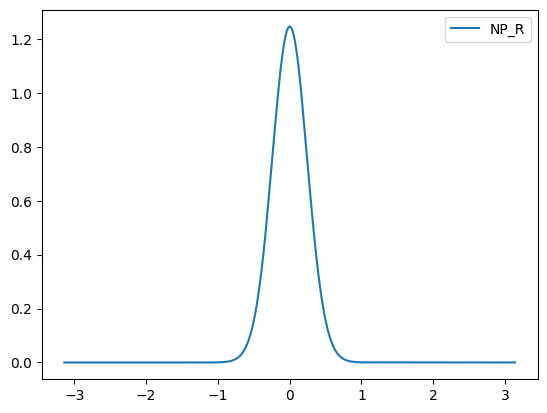

In [ ]:
phi = math.pi
np1 = []
phis = []
while True:
    if phi < -math.pi: break
    np1.append(math.exp(17 * math.cos(phi) - 16.78))
    
    phis.append(phi)
    phi -= 0.001

plt.plot(phis, np1, label = "NP_R") 
plt.legend() 
plt.show()

In [ ]:
theta = math.pi
C = 0.8
t1 = []
thetas = []
while True:
    if theta < -math.pi: break
    t1.append(C ** (0.8 / math.cos(theta)))
    
    thetas.append(theta)
    theta -= 0.001

plt.plot(thetas, t1, label = "NP_R") 
plt.legend() 
plt.show()

TypeError: list.append() takes exactly one argument (2 given)